In [1]:
!git clone https://github.com/a80-abbasi/DeepLearningAssignments.git

Cloning into 'DeepLearningAssignments'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 164 (delta 12), reused 77 (delta 10), pack-reused 84
Receiving objects: 100% (164/164), 88.52 MiB | 17.74 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
%cd "DeepLearningAssignments/Assignment 4/Q1"

/content/DeepLearningAssignments/Assignment 4/Q1


# Preparing Data

In [3]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394484 sha256=edd49df9c04be4f004ff0a10a73dd237c3e3b37ebc5c4e8cb3fb4d6b2056c971
  Stored in directory: /root/.cache/pip/wheels/19/1d/3a/0a8c14c30132b4f9ffd796efbb6746f15b3d6bcfc1055a9346
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp38-cp38-linux_x86_64.whl size=180795 sha256=0fb96ea1ce352cc152b611677b438d9abb98a22ac2529df52d7052dc9827abfa
  Stored in directory: /root/.cache/pip/wheels/3c/d8/9f/59fd78b2b7d1e9ffcb68fb6de80c2e7c20b804c8cbc4d8fc23
Successfully built nltk libwapiti
  Attempting unin

In [4]:
from hazm import *
import string
import os
from pathlib import Path
import numpy as np

In [5]:
with open('ferdousi.txt', 'r', encoding='utf-8') as f:
    half_verses = f.read()
    half_verses = half_verses.split('\n')[2:]
len(half_verses)

99217

I'm gonna train on Mesra's instead of Beits, since the Beits in the data are not in correct order.

In [6]:
# # to remove the last Mesra
half_verses = half_verses[:-1]
# verses = []
# for i in range(0, len(half_verses), 2):
#     verses.append(f'{half_verses[i]} {half_verses[i+1]}')
verses = half_verses
len(verses)

99216

In [7]:
stopwords = []
replace_dict = {}
punctuations = '\.:!،؛؟»\]\)\}«\[\(\{' + string.punctuation

with open('stopwords.txt', 'r', encoding='utf-8') as f:
    var = f.readline()
    while var:
        stopwords.append(var.strip())
        var = f.readline()

with open('replace.txt', 'r', encoding='utf-8') as f:
    line = f.readline()
    while line:
        key, value = line.split('-')
        key, value = key.strip(), value.strip()
        replace_dict[f'{key}'] = f'{value}'
        line = f.readline()

In [8]:
normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()

def replace_function(string):
    if string in replace_dict:
      return replace_dict[string]
    return string

def sent_pre_process(sentence, normalize=True, remove_stopwords=False, stemme=False, lemmatize=True, replace=True, remove_punctuations=True, is_first=True):

    # replace some charachters
    replace_char = {'هٔ': 'ه',
                    'ۀ' : 'ه',
                    'ه‌ی' : 'ه'}
    
    if remove_punctuations:
      for char in punctuations:
        replace_char[char] = " "

    for key, value in replace_char.items():
        sentence = sentence.replace(key, value)

    if normalize:
        sentence = normalizer.normalize(sentence)
    if stemme:
        sentence = stemmer.stemme(sentence)
    if lemmatize:
        sentence = lemmatizer.lemmatize(sentence)
    

    tokens = word_tokenize(sentence)
    
    if replace:
        tokens = [replace_function(token) for token in tokens]
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stopwords]
    
    if is_first:
        return sent_pre_process(" ".join(tokens), normalize, remove_stopwords, stemme, lemmatize, replace, remove_punctuations, False)
    
    return tokens

In [9]:
processed_verses = [sent_pre_process(verse) for verse in verses]

In [10]:
processed_verses[0]

['به', 'نام', 'خداوند', 'جان', 'و', 'خرد']

In [11]:
start, end, pad, unkown = '<s>', '</s>', '<pad>', '<unk>'
# add special tokens
verse_tokens = [[start] + verse + [end] for verse in processed_verses]

In [12]:
all_tokens = set([word for verse in verse_tokens for word in verse])
all_tokens = [pad, unkown] + list(all_tokens)

# converting words to numbers
word2idx = {word: i for i, word in enumerate(all_tokens)}
idx2word = {i: word for word, i in word2idx.items()}

In [13]:
unkown_idx = word2idx[unkown]
pad_idx = word2idx[pad]
start_idx = word2idx[start]
end_idx = word2idx[end]

def verse_to_numbers(verse):
    return [word2idx.get(word, unkown_idx) for word in verse]

def numbers_to_verse(numbers):
    verse = []
    for number in numbers:
        if number == unkown_idx:
            verse.append(unkown)
            continue
        verse.append(idx2word[number])
        if number == end_idx:
            break
    return verse

In [14]:
# convert verses to list of numbers
tokens_idx = [verse_to_numbers(verse) for verse in verse_tokens]

# Preparing Datasets

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import accuracy_score

In [16]:
X = tokens_idx
X = [torch.tensor(x) for x in X]
X = pad_sequence(X, batch_first=True, padding_value=pad_idx)
print(X.shape)
X = F.pad(X, (0, 3, 0, 0), value=pad_idx)
print(X.shape)

with torch.no_grad():
    X, Y = X.clone()[::2], X.clone()[1::2]
    train_set = TensorDataset(X, Y)

torch.Size([99216, 13])
torch.Size([99216, 16])


In [17]:
train_len = int(len(train_set) * 0.85)
val_len = len(train_set) - train_len
train_set, val_set = random_split(train_set, [train_len, val_len])

In [18]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True)

# Model

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
class VersePredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, model_type='lstm',
                        num_layers=1, bidirectional=False, dropout=0, max_T=30, pad_idx=pad_idx):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.model_type = model_type
        if model_type == 'lstm':
            self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
            self.decoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif model_type == 'gru':
            self.encoder = nn.GRU(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
            self.decoder = nn.GRU(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * (bidirectional + 1), vocab_size)
        self.max_T = max_T
        self.dropout = nn.Dropout(dropout)
        self.pad_idx = pad_idx

    def forward(self, x, y):
        x = self.embedding(x)
        y = self.embedding(y)
        _, x = self.encoder(x)
        # x = self.dropout(x)
        x, _ = self.decoder(y, x)
        x = self.fc(x)
        return x

    def loss(self, x, y, acc=False):
        x = self(x, y)
        # drop the first word of y
        y = y[:, 1:].reshape(-1)
        x = x[:, :-1].reshape(-1, x.shape[-1])
        loss = F.cross_entropy(x, y, ignore_index=self.pad_idx)
        if acc:
            acc = accuracy_score(y.cpu().numpy(), x.argmax(dim=-1).cpu().numpy())
            return loss, acc
        return loss

    def predict(self, x):
        input_embd = self.embedding(torch.tensor(start_idx).to(device))
        input_embds = input_embd.repeat(x.shape[0], 1, 1)
        result = torch.zeros(x.shape[0], self.max_T, dtype=torch.long)

        x = self.embedding(x)
        _, hidden_states = self.encoder(x)
        # x = self.dropout(x)
        words_idxs = torch.arange(self.vocab_size, device=device)

        for i in range(self.max_T):
            x, hidden_states = self.decoder(input_embds, hidden_states)
            x = x.squeeze(1)
            x = self.fc(x)
            probs = F.softmax(x, dim=-1)
            idx = probs.multinomial(1)[:, 0]
            x = words_idxs[idx]
            result[:, i] = x
            input_embds = self.embedding(x).reshape(x.shape[0], 1, -1)
        return result

# Training

In [21]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [22]:
def train(model, train_loader, val_loader, optimizer, epochs, device, name='model'):

    history = {'train': [], 'val': [], 'val-acc': [], 'train-acc': []}
    min_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        true_num = 0
        with tqdm(val_loader, total=len(val_loader)) as pbar:
            for x, y in pbar:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                loss, acc = model.loss(x, y, acc=True)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * x.shape[0]
                true_num += acc * x.shape[0]
                pbar.set_description(f'{epoch}: Train Loss: {train_loss / len(train_loader):.3e}')
        train_loss /= len(train_loader)
        train_acc = true_num / len(train_loader)
        
        model.eval()
        val_loss = 0
        true_num = 0
        with torch.no_grad(), tqdm(val_loader, total=len(val_loader)) as pbar:
            for x, y in pbar:
                x, y = x.to(device), y.to(device)
                loss, acc = model.loss(x, y, acc=True)
                val_loss += loss.item() * x.shape[0]
                true_num += acc * x.shape[0]
                pbar.set_description(f'{epoch}: Val Loss: {val_loss / len(val_loader):.3e}')
        val_loss /= len(val_loader)
        val_acc = true_num / len(val_loader)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), f'{name}.pt')
        
        print('-'*100)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        history['train-acc'].append(train_acc)
        history['val-acc'].append(val_acc)

    plt.plot(history['train'], label='train')
    plt.plot(history['val'], label='val')
    plt.legend()
    plt.suptitle('Loss')
    plt.show()
    plt.plot(history['train-acc'], label='train-acc')
    plt.plot(history['val-acc'], label='val-acc')
    plt.legend()
    plt.suptitle('Accuracy')
    plt.show()

In [23]:
model = VersePredictor(len(word2idx), embedding_dim=256, hidden_dim=512, dropout=0.3, num_layers=3).to(device)

0: Val Loss: 7.549e+02: 100%|██████████| 59/59 [00:01<00:00, 33.75it/s]


----------------------------------------------------------------------------------------------------


1: Val Loss: 7.382e+02: 100%|██████████| 59/59 [00:01<00:00, 33.32it/s]


----------------------------------------------------------------------------------------------------


2: Val Loss: 7.307e+02: 100%|██████████| 59/59 [00:01<00:00, 33.21it/s]


----------------------------------------------------------------------------------------------------


3: Val Loss: 7.186e+02: 100%|██████████| 59/59 [00:01<00:00, 32.94it/s]


----------------------------------------------------------------------------------------------------


4: Val Loss: 7.105e+02: 100%|██████████| 59/59 [00:01<00:00, 32.82it/s]


----------------------------------------------------------------------------------------------------


5: Val Loss: 6.985e+02: 100%|██████████| 59/59 [00:01<00:00, 32.31it/s]


----------------------------------------------------------------------------------------------------


6: Val Loss: 6.886e+02: 100%|██████████| 59/59 [00:01<00:00, 32.29it/s]


----------------------------------------------------------------------------------------------------


7: Val Loss: 6.807e+02: 100%|██████████| 59/59 [00:01<00:00, 32.28it/s]


----------------------------------------------------------------------------------------------------


8: Val Loss: 6.728e+02: 100%|██████████| 59/59 [00:01<00:00, 32.23it/s]


----------------------------------------------------------------------------------------------------


9: Val Loss: 6.649e+02: 100%|██████████| 59/59 [00:01<00:00, 32.23it/s]


----------------------------------------------------------------------------------------------------


10: Val Loss: 6.575e+02: 100%|██████████| 59/59 [00:01<00:00, 32.56it/s]


----------------------------------------------------------------------------------------------------


11: Val Loss: 6.504e+02: 100%|██████████| 59/59 [00:01<00:00, 32.67it/s]


----------------------------------------------------------------------------------------------------


12: Val Loss: 6.432e+02: 100%|██████████| 59/59 [00:01<00:00, 32.72it/s]


----------------------------------------------------------------------------------------------------


13: Val Loss: 6.371e+02: 100%|██████████| 59/59 [00:01<00:00, 32.74it/s]


----------------------------------------------------------------------------------------------------


14: Val Loss: 6.277e+02: 100%|██████████| 59/59 [00:01<00:00, 32.71it/s]


----------------------------------------------------------------------------------------------------


15: Val Loss: 6.193e+02: 100%|██████████| 59/59 [00:01<00:00, 32.70it/s]


----------------------------------------------------------------------------------------------------


16: Val Loss: 6.126e+02: 100%|██████████| 59/59 [00:01<00:00, 32.50it/s]


----------------------------------------------------------------------------------------------------


17: Val Loss: 6.020e+02: 100%|██████████| 59/59 [00:01<00:00, 32.60it/s]


----------------------------------------------------------------------------------------------------


18: Val Loss: 5.930e+02: 100%|██████████| 59/59 [00:01<00:00, 32.34it/s]


----------------------------------------------------------------------------------------------------


19: Val Loss: 5.840e+02: 100%|██████████| 59/59 [00:01<00:00, 32.16it/s]


----------------------------------------------------------------------------------------------------


20: Val Loss: 5.723e+02: 100%|██████████| 59/59 [00:01<00:00, 32.31it/s]


----------------------------------------------------------------------------------------------------


21: Val Loss: 5.626e+02: 100%|██████████| 59/59 [00:01<00:00, 32.43it/s]


----------------------------------------------------------------------------------------------------


22: Val Loss: 5.529e+02: 100%|██████████| 59/59 [00:01<00:00, 32.58it/s]


----------------------------------------------------------------------------------------------------


23: Val Loss: 5.440e+02: 100%|██████████| 59/59 [00:01<00:00, 32.37it/s]


----------------------------------------------------------------------------------------------------


24: Val Loss: 5.345e+02: 100%|██████████| 59/59 [00:01<00:00, 32.33it/s]


----------------------------------------------------------------------------------------------------


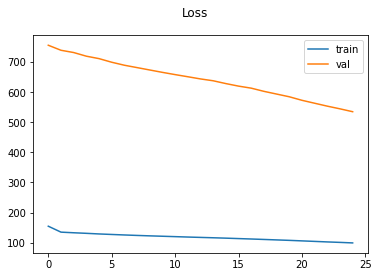

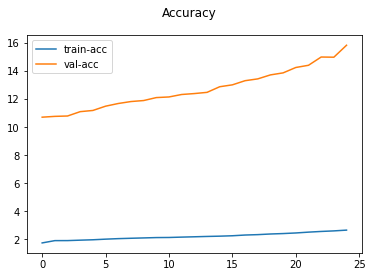

In [126]:
lr = 0.0005
epochs = 25
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_loader, val_loader, optimizer, epochs, device, name='lstm')

# Testing on Train and Validation Data

In [29]:
def print_samples(set, n=5):
    for i in range(n):
        idx = np.random.randint(len(set))
        x, y = set[idx]
        x, y = x.to(device), y.to(device)
        print('Input verse:')
        print(' '.join(numbers_to_verse(x.clone().cpu().numpy())))
        print('Next verse prediction:')
        for i in range(2):
            print(f'prediction {i+1}:')
            y_pred = model.predict(x.unsqueeze(0).to(device))
            print(' '.join(numbers_to_verse(y_pred.cpu().numpy()[0])))
        print('Real next verse:')
        print(' '.join(numbers_to_verse(y.cpu().numpy())))
        print()

In [128]:
# sample predictions in validation set
model.load_state_dict(torch.load('lstm.pt'))
model.to(device)
model.eval()

print_samples(val_set)

Input verse:
<s> برفتند و گفتند کای خفته مرد </s>
Next verse prediction:
prediction 1:
از بکندی گرزش همی انجمن </s>
prediction 2:
ترا گردیده باره از درگاه </s>
Real next verse:
<s> ازین خواب برخیز و بیدار گرد </s>

Input verse:
<s> چه گویید پیران که با این پسر </s>
Next verse prediction:
prediction 1:
زمین بر بخت کابلستان ببرد </s>
prediction 2:
نداند از خواب رستخیز </s>
Real next verse:
<s> چه نیکو بود کار کردن پدر </s>

Input verse:
<s> به گیتی خبر شد که کاووس شاه </s>
Next verse prediction:
prediction 1:
تن چرخ شد پسر زال شاه نیست </s>
prediction 2:
بپوشم خردمند پیش نبرد </s>
Real next verse:
<s> از مازندران بستد آن تاج و گاه </s>

Input verse:
<s> هرانکس که او را بدیدی به راه </s>
Next verse prediction:
prediction 1:
به جوش بسیار نوذر رسید </s>
prediction 2:
که از باب نهادست تیره راه </s>
Real next verse:
<s> بپرسیدی او را از توران سپاه </s>

Input verse:
<s> کنون کاین سپاه عدو گشت پست </s>
Next verse prediction:
prediction 1:
بفرمود هم شد در موم جوی </s>
prediction 2:
برفتند اندرو

In [129]:
print_samples(train_set)

Input verse:
<s> دوباره از لشکر هزاران هزار </s>
Next verse prediction:
prediction 1:
روانش از درد کیهان شد </s>
prediction 2:
همه جام او یادگار در خورست </s>
Real next verse:
<s> سپه بود با آلت کارزار </s>

Input verse:
<s> کزین پس دل از راستی نشکنیم </s>
Next verse prediction:
prediction 1:
همان زابلستان ببسته سزید </s>
prediction 2:
که آهو بادا بران آشتی گو </s>
Real next verse:
<s> همی بیخ کژی از بن برکنیم </s>

Input verse:
<s> یکی تاج زرینش بر سر نهیم </s>
Next verse prediction:
prediction 1:
بدان کوه تابوت را به تنگ </s>
prediction 2:
دیگر گویی توازشهرمن بدست </s>
Real next verse:
<s> همان تخت او بر دو پیکر نهیم </s>

Input verse:
<s> همه مهتران نزد شاه آمدند </s>
Next verse prediction:
prediction 1:
بکرد اندرون ایمن راست </s>
prediction 2:
عمار راه برآورد و بلاش </s>
Real next verse:
<s> برهنه سر و بی کلاه آمدند </s>

Input verse:
<s> بکاوس کی کرد خود آنچ کرد </s>
Next verse prediction:
prediction 1:
همان یازد از کس ترا بازجوی راست </s>
prediction 2:
که کس هوا را رهنمای دهم </s

# GRU

In [66]:
model = VersePredictor(len(word2idx), embedding_dim=256, hidden_dim=512, dropout=0.3, num_layers=3, bidirectional=False, model_type='gru').to(device)
model

VersePredictor(
  (embedding): Embedding(19059, 256, padding_idx=0)
  (encoder): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (decoder): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=512, out_features=19059, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

0: Val Loss: 7.105e+02: 100%|██████████| 59/59 [00:01<00:00, 31.84it/s]


----------------------------------------------------------------------------------------------------


1: Val Loss: 6.950e+02: 100%|██████████| 59/59 [00:01<00:00, 31.29it/s]


----------------------------------------------------------------------------------------------------


2: Val Loss: 6.813e+02: 100%|██████████| 59/59 [00:01<00:00, 31.81it/s]


----------------------------------------------------------------------------------------------------


3: Val Loss: 6.674e+02: 100%|██████████| 59/59 [00:01<00:00, 32.08it/s]


----------------------------------------------------------------------------------------------------


4: Val Loss: 6.542e+02: 100%|██████████| 59/59 [00:01<00:00, 33.02it/s]


----------------------------------------------------------------------------------------------------


5: Val Loss: 6.391e+02: 100%|██████████| 59/59 [00:01<00:00, 33.08it/s]


----------------------------------------------------------------------------------------------------


6: Val Loss: 6.222e+02: 100%|██████████| 59/59 [00:01<00:00, 33.18it/s]


----------------------------------------------------------------------------------------------------


7: Val Loss: 6.049e+02: 100%|██████████| 59/59 [00:01<00:00, 33.20it/s]


----------------------------------------------------------------------------------------------------


8: Val Loss: 5.864e+02: 100%|██████████| 59/59 [00:01<00:00, 32.91it/s]


----------------------------------------------------------------------------------------------------


9: Val Loss: 5.717e+02: 100%|██████████| 59/59 [00:01<00:00, 32.92it/s]


----------------------------------------------------------------------------------------------------


10: Val Loss: 5.517e+02: 100%|██████████| 59/59 [00:01<00:00, 32.62it/s]


----------------------------------------------------------------------------------------------------


11: Val Loss: 5.331e+02: 100%|██████████| 59/59 [00:01<00:00, 32.58it/s]


----------------------------------------------------------------------------------------------------


12: Val Loss: 5.170e+02: 100%|██████████| 59/59 [00:01<00:00, 32.40it/s]


----------------------------------------------------------------------------------------------------


13: Val Loss: 4.982e+02: 100%|██████████| 59/59 [00:01<00:00, 31.99it/s]


----------------------------------------------------------------------------------------------------


14: Val Loss: 4.836e+02: 100%|██████████| 59/59 [00:01<00:00, 32.39it/s]


----------------------------------------------------------------------------------------------------


15: Val Loss: 4.669e+02: 100%|██████████| 59/59 [00:01<00:00, 32.51it/s]


----------------------------------------------------------------------------------------------------


16: Val Loss: 4.499e+02: 100%|██████████| 59/59 [00:01<00:00, 32.87it/s]


----------------------------------------------------------------------------------------------------


17: Val Loss: 4.341e+02: 100%|██████████| 59/59 [00:01<00:00, 32.87it/s]


----------------------------------------------------------------------------------------------------


18: Val Loss: 4.188e+02: 100%|██████████| 59/59 [00:01<00:00, 32.56it/s]


----------------------------------------------------------------------------------------------------


19: Val Loss: 4.024e+02: 100%|██████████| 59/59 [00:01<00:00, 33.11it/s]


----------------------------------------------------------------------------------------------------


20: Val Loss: 3.876e+02: 100%|██████████| 59/59 [00:01<00:00, 32.53it/s]


----------------------------------------------------------------------------------------------------


21: Val Loss: 3.738e+02: 100%|██████████| 59/59 [00:01<00:00, 32.86it/s]


----------------------------------------------------------------------------------------------------


22: Val Loss: 3.604e+02: 100%|██████████| 59/59 [00:01<00:00, 32.70it/s]


----------------------------------------------------------------------------------------------------


23: Val Loss: 3.462e+02: 100%|██████████| 59/59 [00:01<00:00, 32.68it/s]


----------------------------------------------------------------------------------------------------


24: Val Loss: 3.325e+02: 100%|██████████| 59/59 [00:01<00:00, 32.87it/s]


----------------------------------------------------------------------------------------------------


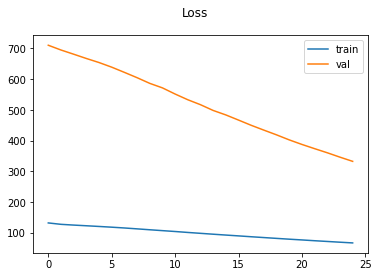

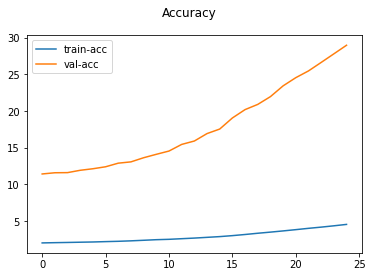

In [68]:
lr = 0.0005
epochs = 25
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_loader, val_loader, optimizer, epochs, device, name='gru')

In [69]:
# sample predictions in validation set
model.load_state_dict(torch.load('gru.pt'))
# model.to(device)
model.eval()

print_samples(val_set)

Input verse:
<s> سر سروران در آمد به تنگ </s>
Next verse prediction:
prediction 1:
از تیمار وز گوهر نابسود </s>
prediction 2:
بمردی و اندوه آمدش را بدی </s>
Real next verse:
<s> سزد‌گر بسازیم با شاه جنگ </s>

Input verse:
<s> بیاورد زان پس صد و سی هزار </s>
Next verse prediction:
prediction 1:
گدازیده آمد از کردار او پر از فسرد </s>
prediction 2:
بدشمن سپارد خرد داد نام </s>
Real next verse:
<s> از گنجی که بود از پدر یادگار </s>

Input verse:
<s> یکی نامه بنوشت نزدیک اوی </s>
Next verse prediction:
prediction 1:
میان برسان ایران نبرد </s>
prediction 2:
رخ نیز بر دلیران به داد </s>
Real next verse:
<s> پر از دانش و رامش و رنگ و بوی </s>

Input verse:
<s> بدو گفت رستم که‌ای پهلوان </s>
Next verse prediction:
prediction 1:
برو خواستند باید سپاه </s>
prediction 2:
هنرهای از آگندن نابسود </s>
Real next verse:
<s> جهاندار و بیدار و روشن روان </s>

Input verse:
<s> چنین داد پاسخ که داننده مرد </s>
Next verse prediction:
prediction 1:
از ما کسی رفت در پیشگاه </s>
prediction 2:
کزین من با هر در

In [70]:
print_samples(train_set)

Input verse:
<s> سپه را همی دل شکسته کنی </s>
Next verse prediction:
prediction 1:
چرا مرده مهراب را خزان </s>
prediction 2:
برآرند شد به کس فرزند اسپ </s>
Real next verse:
<s> به گفتار بی جنگ خسته کنی </s>

Input verse:
<s> دل شیده کشت در آن کار تنگ </s>
Next verse prediction:
prediction 1:
سپهبد خوشی من شسته پیش </s>
prediction 2:
یکی رستخیز سوی جای جفت </s>
Real next verse:
<s> همی باز خواند آن یلانرا از جنگ </s>

Input verse:
<s> گرانمایه شاه جهان کدخدای </s>
Next verse prediction:
prediction 1:
سپاهی آراسته زمین زیرگاه </s>
prediction 2:
که با من شود سست دردست گشت </s>
Real next verse:
<s> به کرسی زرین ورا کرد جای </s>

Input verse:
<s> نگه کرد باید بدین تازه بوم </s>
Next verse prediction:
prediction 1:
بیامد بران تاج جوینده انجمن </s>
prediction 2:
کمندی از تیغ شاهی بسی </s>
Real next verse:
<s> که آباد بادا همه مرز روم </s>

Input verse:
<s> ترا بیشتر نزد من دستگاه </s>
Next verse prediction:
prediction 1:
گرانمایگان بگردم بود مرد راز </s>
prediction 2:
نمانم به گرز از در ایشان